# Lag-Llama fine tuning
Finetune the [Lag-Llama model](https://huggingface.co/time-series-foundation-models/Lag-Llama) for predicting BTC price.

- prediction length = 30

Clone and install the required packages for the Lag-Llama architecture

In [1]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

fatal: destination path 'lag-llama' already exists and is not an empty directory.


In [2]:
%pip install -r ./lag-llama/requirements.txt --quiet


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Download the pretrained model weights from HuggingFace

In [3]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir ./lag-llama

Consider using `hf_transfer` for faster downloads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
./lag-llama/lag-llama.ckpt


Imports  
Import the required packages and the lag llama estimator obj, which we can use to make predictions

In [4]:
# Standard library imports
from typing import List, Dict, Tuple
import sys

# Third-party library imports
import numpy as np
import pandas as pd
from pandas._libs.tslibs.timestamps import Timestamp
from tqdm.autonotebook import tqdm
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
import torch
from gluonts.dataset.common import MetaData, TrainDatasets, ListDataset
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from itertools import islice

# Local imports
sys.path.append('./lag-llama/')
from lag_llama.gluon.estimator import LagLlamaEstimator

sys.path.append('../../../')
from coin_data import get_coin_data


/tmp/ipykernel_132007/2382137520.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/home/pahautelman/Projects/bitcoin-bot/bitcoin-bot/bitcoinbot/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Create a function for Lag-Llama inference that we can reuse. This function returns the predictions for the given prediction horizon. The forecast will be of shape (num_samples, prediction_length), where num_samples is the number of samples sampled from the predicted probability distribution for each timestep.

In [5]:
prediction_length = 20
context_length = prediction_length*3
num_samples = 20
batch_size = 64
device = 'cuda'

In [6]:
# TODO: lower batch_size to ie 32 if GPU cant handle it during training
checkpoint_path = "./lag-llama/lag-llama.ckpt"
def get_lag_llama_predictions(dataset, checkpoint_path: str = checkpoint_path, prediction_length: int = prediction_length, context_length: int = context_length, num_samples: int = num_samples, device: str = device, batch_size: int = batch_size, nonnegative_pred_samples: bool = True):
    # num_samples is the number of samples sampled from the predicted probability distribution for each timestep
    
    ckpt = torch.load(checkpoint_path, map_location=device)
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path=checkpoint_path,
        prediction_length=prediction_length,
        context_length=context_length,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        nonnegative_pred_samples=nonnegative_pred_samples,

        # linear positional encoding scaling
        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        },

        batch_size=batch_size,
        num_parallel_samples=num_samples,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))
    tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth"))

    return forecasts, tss

Get data

In [7]:
def get_data_splits(data: pd.DataFrame, min_length: int, batch_size: int) -> Tuple[List[List[Dict]], List[List[Dict]], List[List[Dict]]]:
    """
    Splits the data into train, test, and validation sets.

    Args:
        data (pd.DataFrame): DataFrame containing the time series data.
        min_length (int): Minimum length for each batch.
        batch_size (int): number of training batches.

    Returns:
        Tuple[List[List[Dict]], List[List[Dict]], List[List[Dict]]]: Tuple containing three lists:
            - First list contains the train data.
            - Second list contains the test data.
            - Third list contains the validation data.
    
    Details:
        - The `data` DataFrame is split into train (80%), test (10%), and validation (10%) sets.
        - Data sets are batched. The minimum length for each batch is determined as `context_length + prediction_length`.
        - Batches can have lengths greater than the minimum length.
        - If enough data is available, the train set is further split into `batch_size` batches, which should match the training batch size used for the model. Otherwise, the train set has less batches, each batch having length equal to the minimum length.
        - Test and validation sets are batched such that each batch has length equal to the minimum length.
    """
    if len(data) < 10*min_length:
        raise ValueError("Not enough data to generate splits.")

    train_batches = []
    test_batches = []
    validation_batches = []
    
    # Function to create batches from a section of data
    def create_batches(section: pd.DataFrame, batch_length: int) -> List[pd.DataFrame]:
        batches = [section.iloc[i:i+batch_length] for i in range(0, len(section), batch_length) if len(section.iloc[i:i+batch_length]) == batch_length]
        return batches
    
    if 0.8 * len(data) < batch_size * min_length:
        # If train set has less than batch_size batches
        # => train, test, and validation sets have batch length equal to min_length
        # Split data into sections of 10*min_length
        sections = create_batches(data, min_length)
        np.random.shuffle(sections)
        test_batches.append(sections[0])
        validation_batches.append(sections[1])
        train_batches.extend(sections[2:])
    else:
        train_batch_size = int ((len(data) - 2*batch_size*min_length) // batch_size)
        # train_batch_size = int(0.8 * len(data) // batch_size)
        section_size = train_batch_size + 2*min_length
        sections = create_batches(data, section_size)
        for section in sections:
            # randomly select the test and validation batches to be either
            # - the first two batches
            # - the last two batches
            # - the first and last batch
            selected_batches = []
            selection_strategy = np.random.randint(3)
            if selection_strategy == 0:
                selected_batches = [section.iloc[:min_length], section.iloc[min_length:2*min_length]]
                train_batches.append(section.iloc[2*min_length:])
            elif selection_strategy == 1:
                selected_batches = [section.iloc[-2*min_length:-min_length], section.iloc[-min_length:]]
                train_batches.append(section.iloc[:-2*min_length])
            else:
                selected_batches = [section.iloc[:min_length], section.iloc[-min_length:]]
                train_batches.append(section.iloc[min_length:-min_length])
            test_batch_index = np.random.randint(2)
            test_batches.append(selected_batches[test_batch_index])
            validation_batches.append(selected_batches[1-test_batch_index])
    
    return train_batches, test_batches, validation_batches

def get_gluons_dataset(data: pd.DataFrame, target: str = 'Close', freq: str = 'H', prediction_length: int = 30, context_length: int = 90, batch_size: int = batch_size) -> Tuple[TrainDatasets, TrainDatasets]:
    """
    Creates GluonTS datasets from pandas DataFrame.

    Args:
        data (pd.DataFrame): DataFrame containing the time series data.
        target (str): Name of the column that contains the target time series.
        freq (str): Frequency of the data (e.g., 'W', 'D', '1h', etc.).
        prediction_length (int): Length of the prediction horizon.
        context_length (int): Length of the context window.
        batch_size (int): Size of the batches.

    Returns:
        Tuple[TrainDatasets, TrainDatasets]: Tuple containing two GluonTS datasets:
            - First dataset contains the train and test data (access like dataset.train and dataset.test).
            - Second dataset contains the validation data (access like dataset.train).

    Details:
        - The `data` DataFrame is split into train (80%), test (10%), and validation (10%) sets.
        - Data sets are batched. The minimum length for each batch is determined as `context_length + prediction_length`.
        - Batches can have lengths greater than the minimum length.
        - If enough data is available, the train set is further split into `batch_size` batches, which should match the training batch size used for the model. Otherwise, the train set has less batches, each batch having length equal to the minimum length.
        - Test and validation sets are batched such that each batch has length equal to the minimum length.
    """
    train, test, validation = get_data_splits(data, min_length=context_length + prediction_length, batch_size=batch_size)
    
    meta = MetaData(freq=freq, prediction_length=prediction_length)
    
    train_ds = ListDataset([{**{"start": batch.index[0]}, **{"target": batch[target]}} for batch in train], freq=freq)
    test_ds = ListDataset([{**{"start": batch.index[0]}, **{"target": batch[target]}} for batch in test], freq=freq)
    validation_ds = ListDataset([{**{"start": batch.index[0]}, **{"target": batch[target]}} for batch in validation], freq=freq)

    return TrainDatasets(metadata=meta, train=train_ds, test=test_ds), TrainDatasets(metadata=meta, train=validation_ds, test=None)


In [8]:
def extend_coin_data(symbol: str = 'BTC/USDT', train_dataset: TrainDatasets = None, validation_dataset: TrainDatasets = None, start_date: Timestamp = Timestamp('2009-01-03'), end_date: Timestamp = None, freq: str = '1h') -> Tuple[TrainDatasets, TrainDatasets]:
    """
    Extends (or create) the given datasets with the coin data.
    
    Args:
        symbol (str): Symbol of the coin.
        train_dataset (TrainDatasets): Train dataset to extend.
        validation_dataset (TrainDatasets): Validation dataset to extend.
        start_date (Timestamp): Start date for the data.
        end_date (Timestamp): End date for the data.
        freq (str): Frequency of the data (e.g., 'W', 'D', '1h', etc.).

    Returns:
        Tuple[TrainDatasets, TrainDatasets]: Tuple containing the extended train and validation datasets.

    Details:
        - passed TrainDatasets are mutated.
    """
    coin_data = get_coin_data(symbol, start_date=start_date, end_date=end_date, timeframe=freq)
    # if data has nan values, raise warning
    if coin_data.isnull().values.any():
        print("Warning: Data has NaN values.")
    coin_data['Close'] = coin_data['Close'].astype(float)

    if train_dataset is None or validation_dataset is None:
        return get_gluons_dataset(coin_data, freq=freq)
    train_dataset_ext, validation_dataset_ext = get_gluons_dataset(coin_data, freq=freq)
    
    train_dataset.train.extend(train_dataset_ext.train)
    train_dataset.test.extend(train_dataset_ext.test)
    validation_dataset.train.extend(validation_dataset_ext.train)

    return train_dataset, validation_dataset

In [11]:
train, validation = extend_coin_data(symbol='BTC/USDT', start_date=Timestamp('2009-01-03'), freq='1h')
train, validation = extend_coin_data(symbol='ETH/USDT', train_dataset=train, validation_dataset=validation, start_date=Timestamp('2015-08-07'), freq='1h')
train, validation = extend_coin_data(symbol='BNB/USDT', train_dataset=train, validation_dataset=validation, start_date=Timestamp('2017-07-25'), freq='1h')
train, validation = extend_coin_data(symbol='SOL/USDT', train_dataset=train, validation_dataset=validation, start_date=Timestamp('2020-04-10'), freq='1h')
train, validation = extend_coin_data(symbol='ADA/USDT', train_dataset=train, validation_dataset=validation, start_date=Timestamp('2017-10-01'), freq='1h')
train, validation = extend_coin_data(symbol='DOT/USDT', train_dataset=train, validation_dataset=validation, start_date=Timestamp('2020-05-26'), freq='1h')
train, validation = extend_coin_data(symbol='LINK/USDT', train_dataset=train, validation_dataset=validation, start_date=Timestamp('2017-09-24'), freq='1h')

KeyboardInterrupt: 

In [14]:
print(len(train.train))
print(len(train.test))
print(len(validation.train))

448
448
448


In [15]:
forecasts, tss = get_lag_llama_predictions(
    train.test,
    prediction_length=prediction_length,
    num_samples=num_samples,
    context_length=context_length,
    device=device
)

Forecasting batches:   0%|          | 0/448 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/448 [00:00<?, ?it/s]

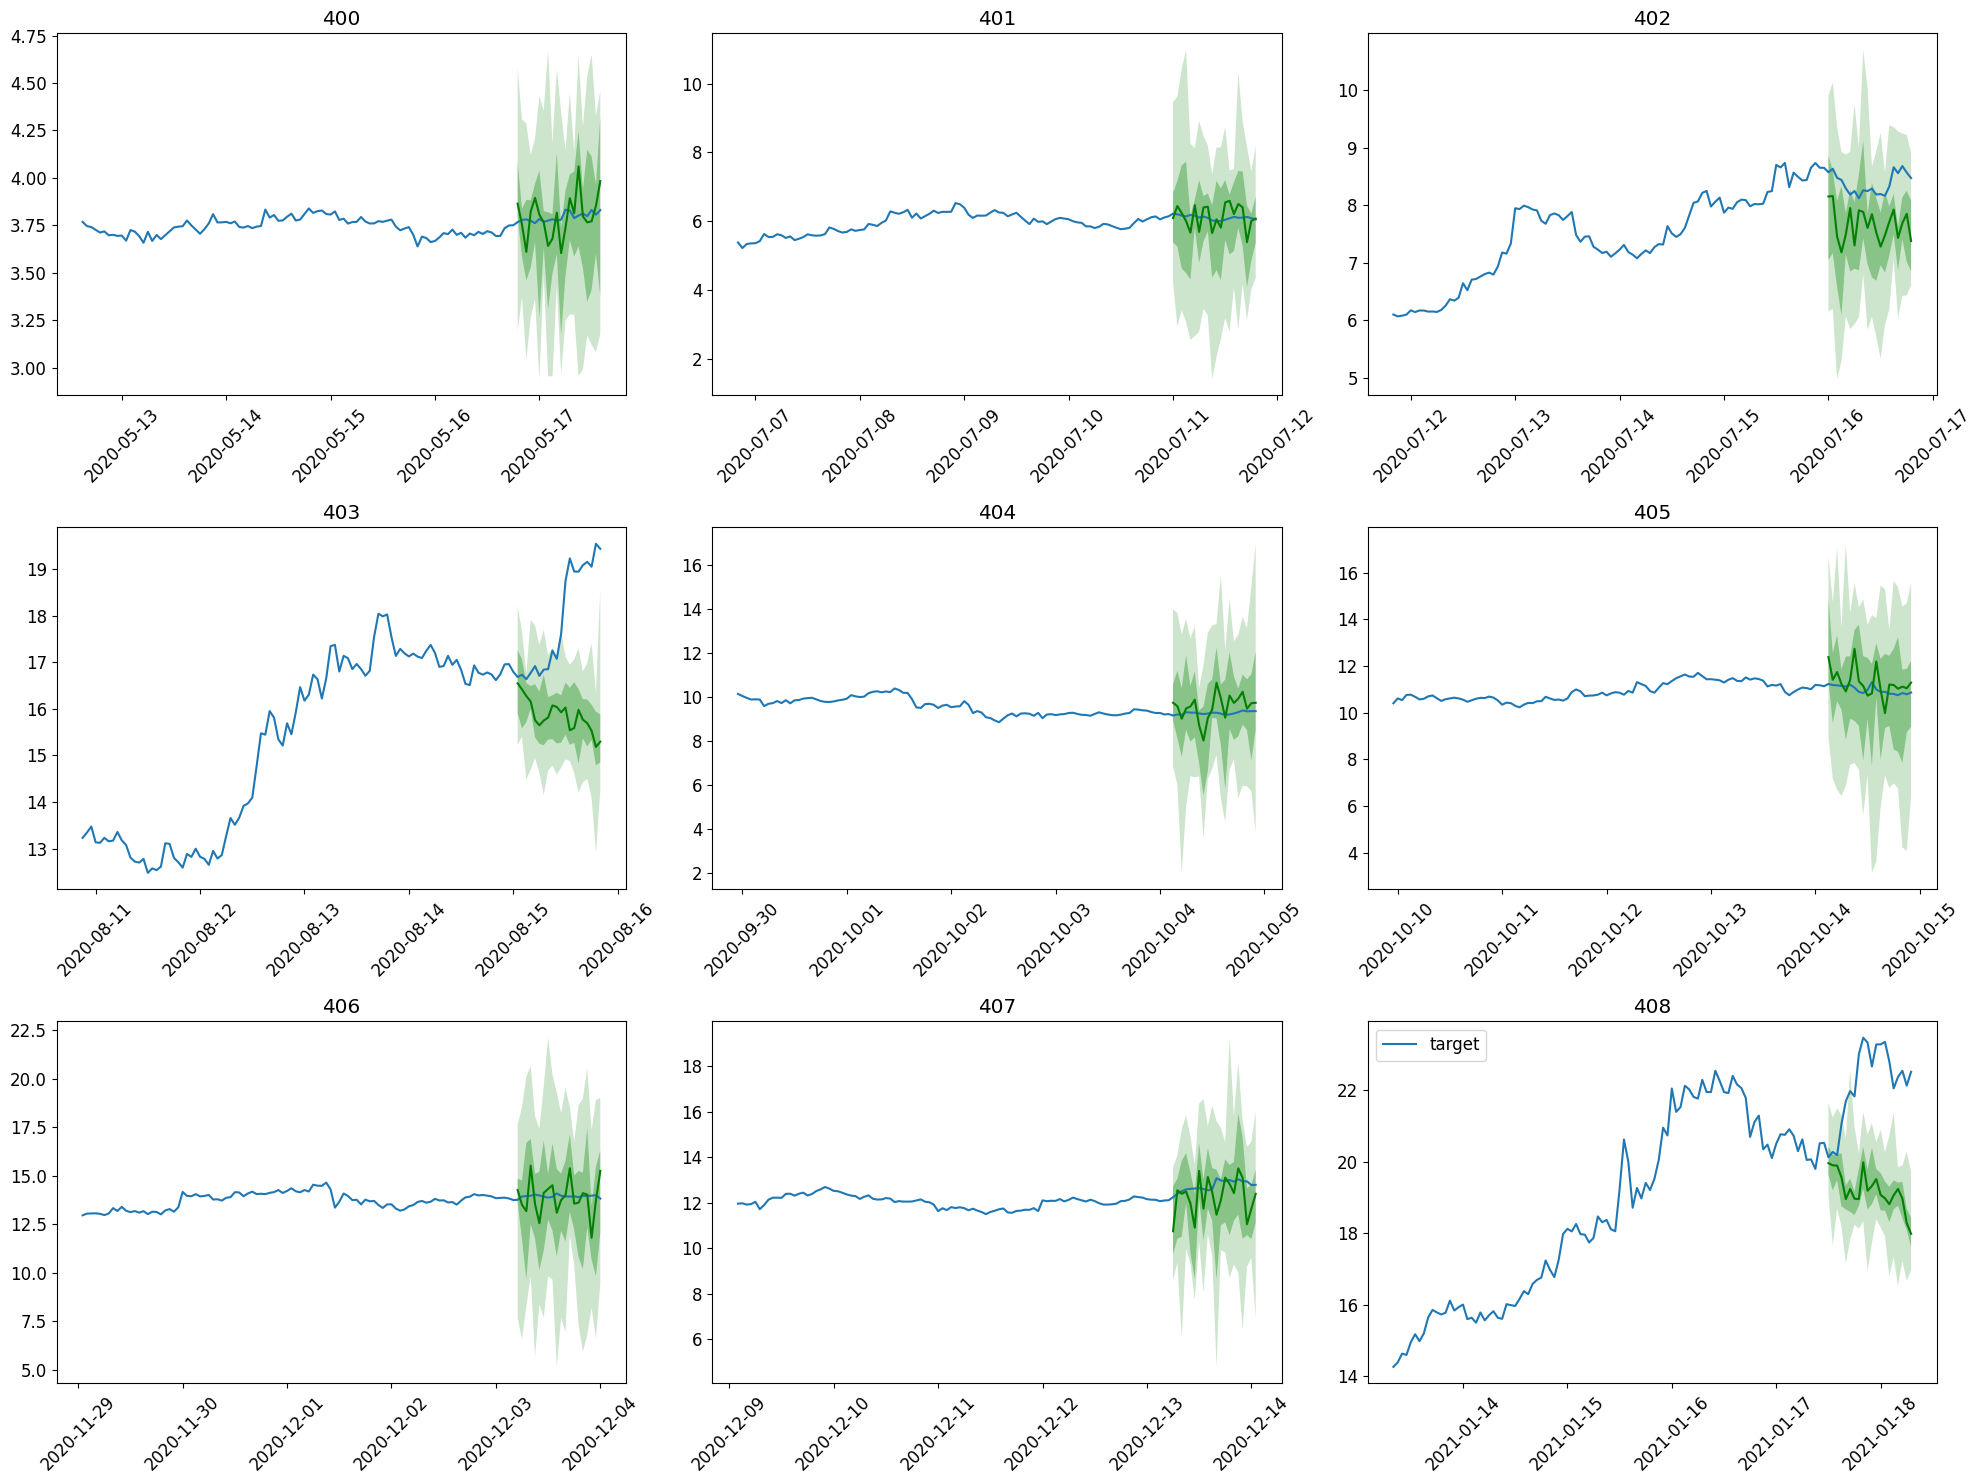

In [22]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 12})

# Iterate through the first 9 series, and plot the predicted samples
start=400
for idx, (forecast, ts) in islice(enumerate(zip(forecasts[start:], tss[start:]), start=start), 9):
    ax = plt.subplot(3, 3, idx-start+1)

    plt.plot(ts[:].to_timestamp(), label="target", )
    forecast.plot(color='g')
    plt.xticks(rotation=45)
    ax.set_title(idx)

plt.gcf().tight_layout()
plt.legend()
plt.show()

Works ig! Time to finetune the model!

In [24]:
ckpt = torch.load("./lag-llama/lag-llama.ckpt", map_location=device)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
        ckpt_path="./lag-llama/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # distr_output="neg_bin",
        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=1e-3,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        # rope_scaling={
        #     "type": "linear",
        #     "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        # },

        batch_size=batch_size,
        num_parallel_samples=num_samples,
        trainer_kwargs = {"max_epochs": 50,}, # <- lightning trainer arguments
    )

In [25]:
1e-2, 5e-3, 1e-3, 5e-3, 1e-4, 5e-4

(0.01, 0.005, 0.001, 0.005, 0.0001, 0.0005)

In [27]:
predictor = estimator.train(train.train, validation_data=validation.train, cache_data=True, shuffle_buffer_length=1000)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'val_loss' reached 2.33899 (best 2.33899), saving model to '/home/pahautelman/Projects/bitcoin-bot/bitcoin-bot/agents/basic/lag_llama/lightning_logs/version_3/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 100: 'val_loss' reached 2.17347 (best 2.17347), saving model to '/home/pahautelman/Projects/bitcoin-bot/bitcoin-bot/agents/basic/lag_llama/lightning_logs/version_3/checkpoints/epoch=1-step=100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 300: 'val_loss' reached 2.09855 (best 2.09855), saving model to '/home/pahautelman/Projects/bitcoin-bot/bitcoin-bot/agents/basic/lag_llama/lightning_logs/version_3/checkpoints/epoch=5-step=300.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 350: 'val_loss' reached 2.07439 (best 2.07439), saving model to '/home/pahautelman/Projects/bitcoin-bot/bitcoin-bot/agents/basic/lag_llama/lightning_logs/version_3/checkpoints/epoch=6-step=350.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 500: 'val_loss' reached 1.77568 (best 1.77568), saving model to '/home/pahautelman/Projects/bitcoin-bot/bitcoin-bot/agents/basic/lag_llama/lightning_logs/version_3/checkpoints/epoch=9-step=500.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 700: 'val_loss' reached 1.43509 (best 1.43509), saving model to '/home/pahautelman/Projects/bitcoin-bot/bitcoin-bot/agents/basic/lag_llama/lightning_logs/version_3/checkpoints/epoch=13-step=700.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 750: 'val_loss' reached 1.38153 (best 1.38153), saving model to '/home/pahautelman/Projects/bitcoin-bot/bitcoin-bot/agents/basic/lag_llama/lightning_logs/version_3/checkpoints/epoch=14-step=750.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 850: 'val_loss' reached 1.26528 (best 1.26528), saving model to '/home/pahautelman/Projects/bitcoin-bot/bitcoin-bot/agents/basic/lag_llama/lightning_logs/version_3/checkpoints/epoch=16-step=850.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 950: 'val_loss' reached 1.23607 (best 1.23607), saving model to '/home/pahautelman/Projects/bitcoin-bot/bitcoin-bot/agents/basic/lag_llama/lightning_logs/version_3/checkpoints/epoch=18-step=950.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 1050: 'val_loss' reached 1.09923 (best 1.09923), saving model to '/home/pahautelman/Projects/bitcoin-bot/bitcoin-bot/agents/basic/lag_llama/lightning_logs/version_3/checkpoints/epoch=20-step=1050.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 1200: 'val_loss' reached 1.09477 (best 1.09477), saving model to '/home/pahautelman/Projects/bitcoin-bot/bitcoin-bot/agents/basic/lag_llama/lightning_logs/version_3/checkpoints/epoch=23-step=1200.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 1500: 'val_loss' reached 1.01157 (best 1.01157), saving model to '/home/pahautelman/Projects/bitcoin-bot/bitcoin-bot/agents/basic/lag_llama/lightning_logs/version_3/checkpoints/epoch=29-step=1500.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30, global step 1550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31, global step 1600: 'val_loss' reached 0.93694 (best 0.93694), saving model to '/home/pahautelman/Projects/bitcoin-bot/bitcoin-bot/agents/basic/lag_llama/lightning_logs/version_3/checkpoints/epoch=31-step=1600.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32, global step 1650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33, global step 1700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34, global step 1750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35, global step 1800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36, global step 1850: 'val_loss' reached 0.91472 (best 0.91472), saving model to '/home/pahautelman/Projects/bitcoin-bot/bitcoin-bot/agents/basic/lag_llama/lightning_logs/version_3/checkpoints/epoch=36-step=1850.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37, global step 1900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38, global step 1950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39, global step 2000: 'val_loss' reached 0.89292 (best 0.89292), saving model to '/home/pahautelman/Projects/bitcoin-bot/bitcoin-bot/agents/basic/lag_llama/lightning_logs/version_3/checkpoints/epoch=39-step=2000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40, global step 2050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41, global step 2100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42, global step 2150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43, global step 2200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44, global step 2250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45, global step 2300: 'val_loss' reached 0.87324 (best 0.87324), saving model to '/home/pahautelman/Projects/bitcoin-bot/bitcoin-bot/agents/basic/lag_llama/lightning_logs/version_3/checkpoints/epoch=45-step=2300.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46, global step 2350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47, global step 2400: 'val_loss' reached 0.81090 (best 0.81090), saving model to '/home/pahautelman/Projects/bitcoin-bot/bitcoin-bot/agents/basic/lag_llama/lightning_logs/version_3/checkpoints/epoch=47-step=2400.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48, global step 2450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 49, global step 2500: 'val_loss' reached 0.80936 (best 0.80936), saving model to '/home/pahautelman/Projects/bitcoin-bot/bitcoin-bot/agents/basic/lag_llama/lightning_logs/version_3/checkpoints/epoch=49-step=2500.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=50` reached.


In [28]:
forecast_it, ts_it = make_evaluation_predictions(
        dataset=train.test,
        predictor=predictor,
        num_samples=num_samples
    )

In [29]:
forecasts = list(tqdm(forecast_it, total=len(train.test), desc="Forecasting batches"))

Forecasting batches:   0%|          | 0/448 [00:00<?, ?it/s]

In [30]:
tss = list(tqdm(ts_it, total=len(train.test), desc="Ground truth"))

Ground truth:   0%|          | 0/448 [00:00<?, ?it/s]

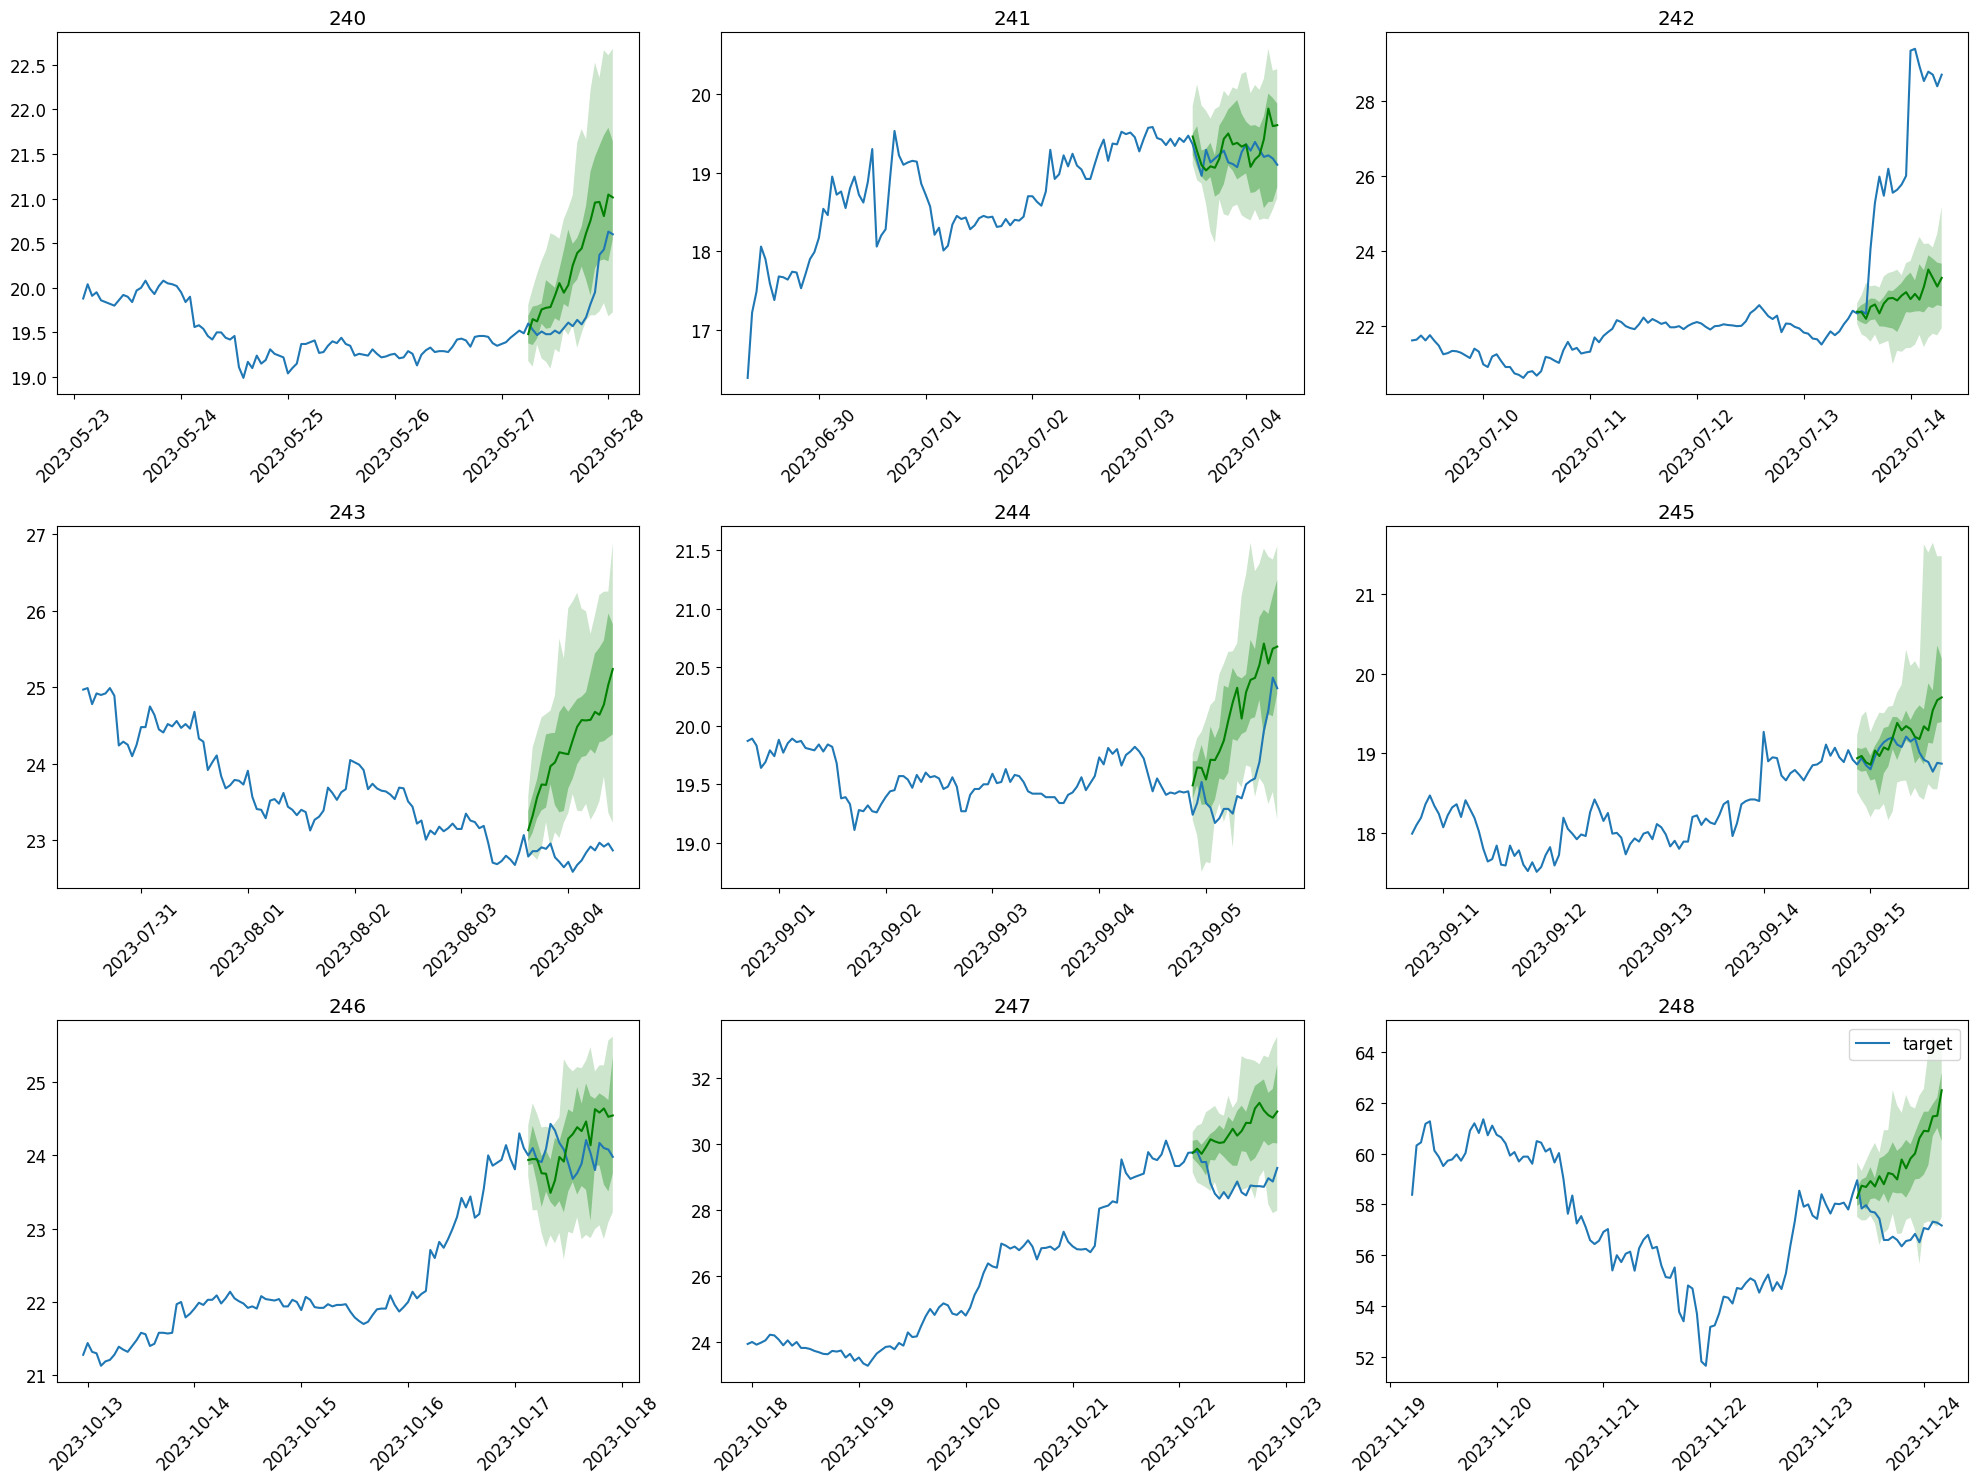

In [55]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 12})

# Iterate through the first 9 series, and plot the predicted samples
start = 240
for idx, (forecast, ts) in islice(enumerate(zip(forecasts[start:], tss[start:]), start), 9):
    ax = plt.subplot(3, 3, idx-start+1)

    plt.plot(ts[:].to_timestamp(), label="target", )
    forecast.plot(color='g')
    plt.xticks(rotation=45)
    ax.set_title(idx)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [56]:
# TODO: eval on latest 2 month BTC data
# TODO: load checkpoint and use model as indicator

# TODO: Idea, add another column to each 'Close' entry encoding whether bullish or bearish longterm conditions. The model would hopefully learn off that and add to the prediction. I dont know if that retarded

In [7]:
def get_two_month_btc_data(freq: str = '1h', prediction_length: int = 30, context_length: int = 90) -> TrainDatasets:
    """
    Returns the two latest months of BTC/USDT data.

    Args:
        freq (str): Frequency of the data (e.g., 'W', 'D', '1h', etc.).
        prediction_length (int): Length of the prediction horizon.
        context_length (int): Length of the context window.

    Returns:
        TrainDatasets: GluonTS dataset containing the two latest months of BTC/USDT data. Use like dataset.train.

    Details:
        - The returned dataset contains time series of lengths 'min_length', which are created by rolling windows over the two latest months of BTC/USDT data.
    """
    end_date = pd.Timestamp.now().floor('h')
    start_date = end_date - pd.DateOffset(months=2)
    coin_data = get_coin_data('BTC/USDT', start_date=start_date, end_date=end_date, timeframe=freq)
    coin_data['Close'] = coin_data['Close'].astype(float)

    min_length = context_length + prediction_length
    if len(coin_data) < min_length:
        raise ValueError("Not enough data to generate dataset.")

    prediction_windows = [coin_data.iloc[i:i+min_length] for i in range(0, len(coin_data)-min_length+1)]    
    meta = MetaData(freq=freq, prediction_length=prediction_length)
    dataset = ListDataset([{**{"start": window.index[0]}, **{"target": window['Close']}} for window in prediction_windows], freq=freq)

    return TrainDatasets(metadata=meta, train=dataset, test=None)

In [8]:
test_btc_data = get_two_month_btc_data(prediction_length=prediction_length, context_length=context_length)

In [9]:
ckpt_path = './lightning_logs/version_3/checkpoints/lag-llama-btc-etc-bnb-sol-ada-dot-link-1h-finetune.ckpt'
forecasts, tss = get_lag_llama_predictions(
    test_btc_data.train,
    checkpoint_path=ckpt_path,
    prediction_length=prediction_length,
    context_length=context_length)

Forecasting batches:   0%|          | 0/1384 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1384 [00:00<?, ?it/s]

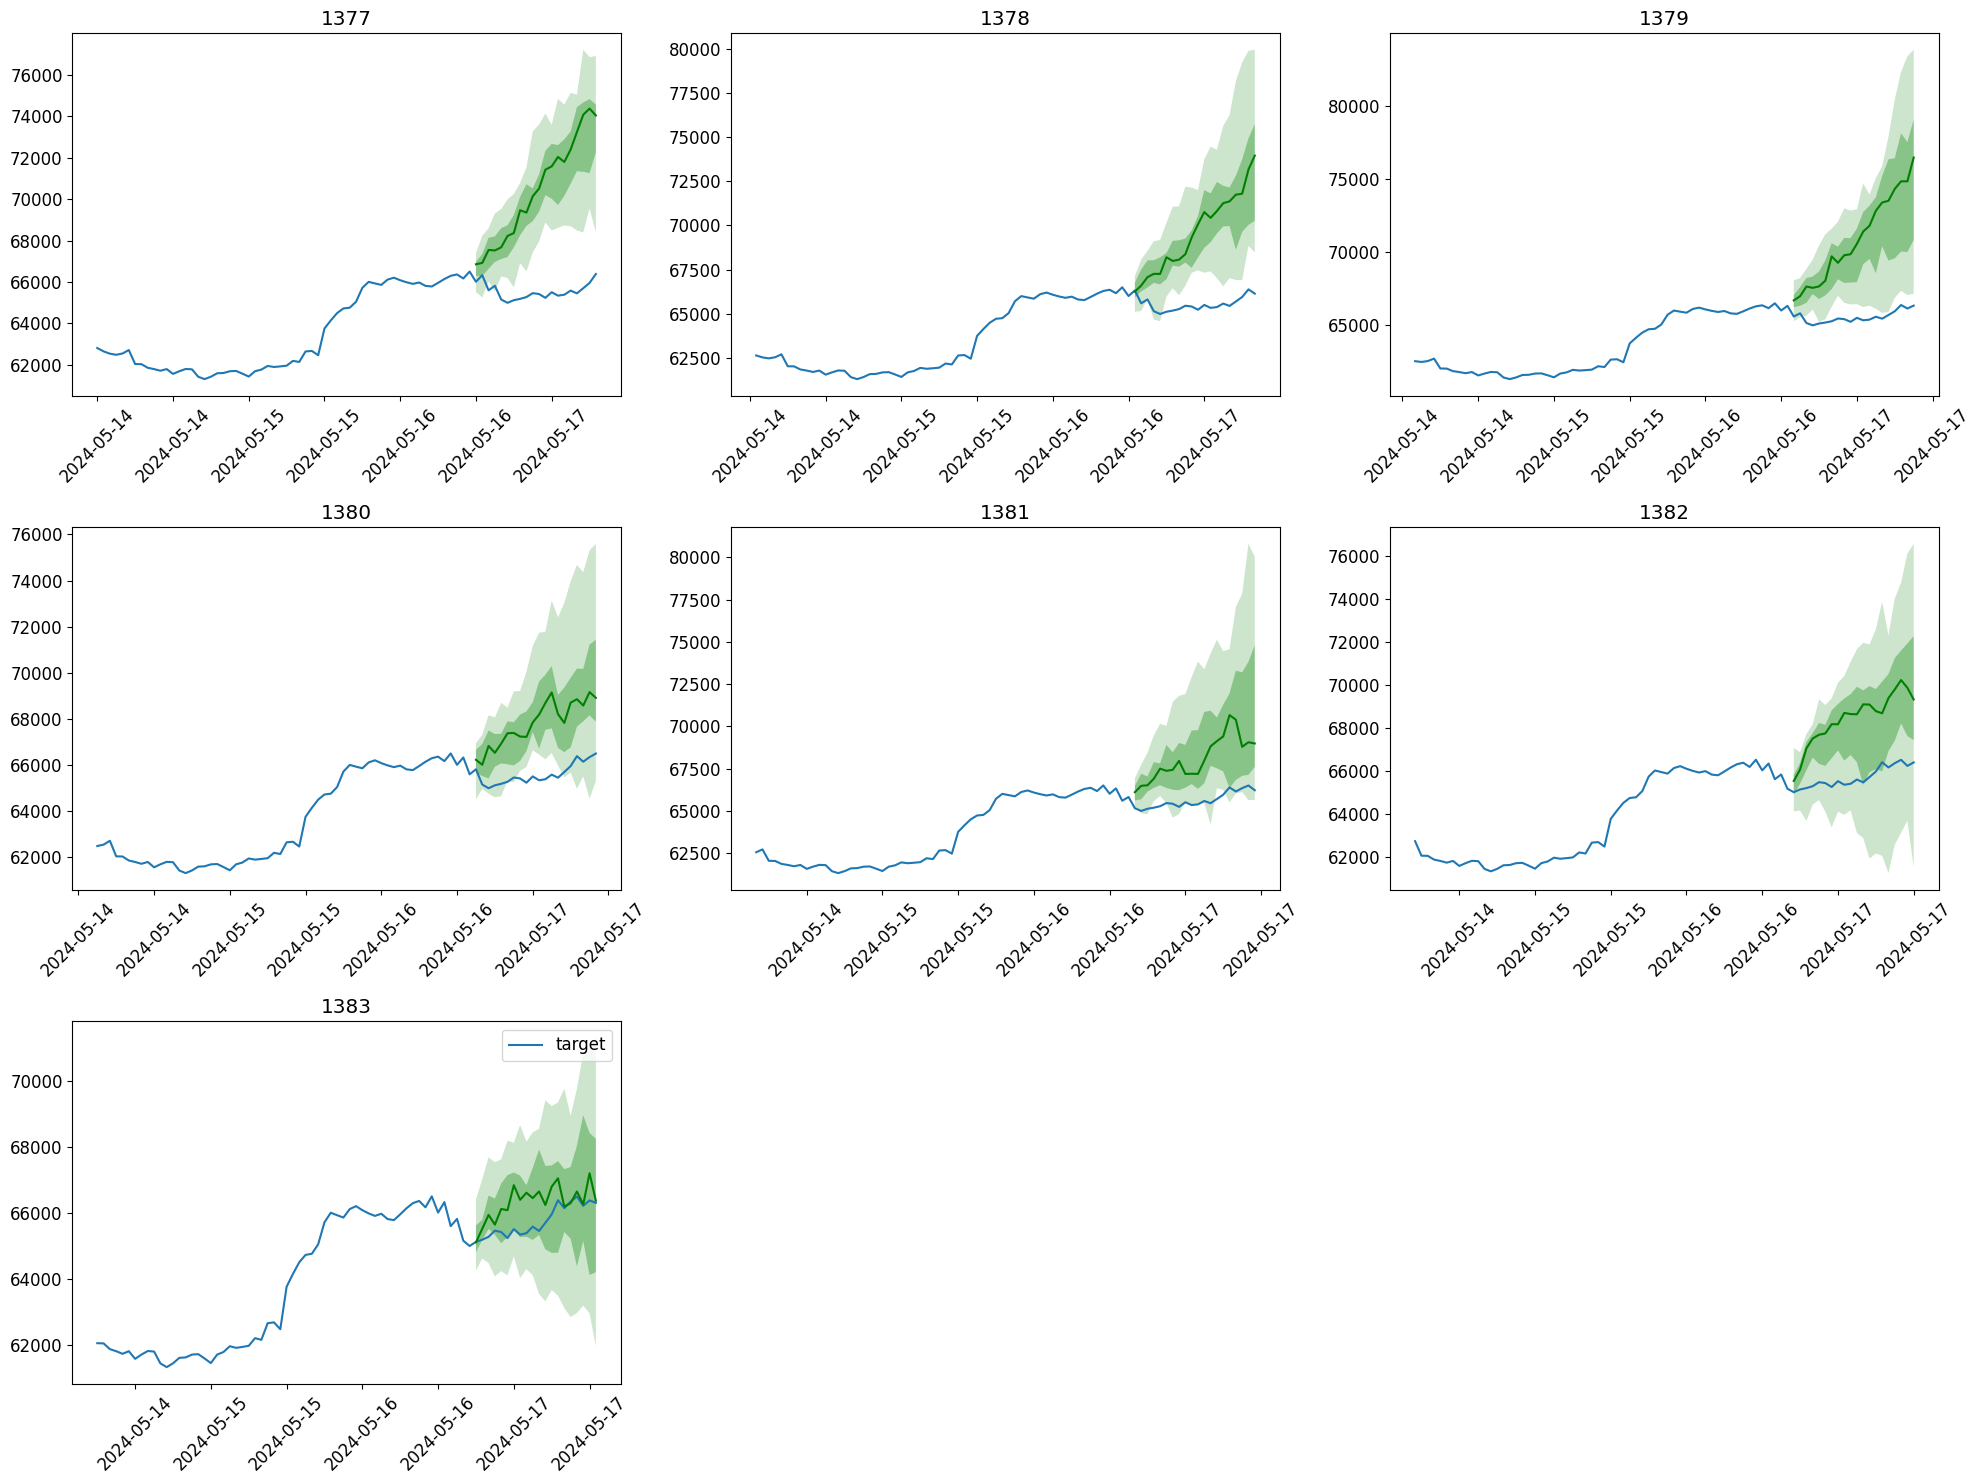

In [12]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%Y-%m-%d')
plt.rcParams.update({'font.size': 12})

# Iterate through the first 9 series, and plot the predicted samples
start = 9*153
for idx, (forecast, ts) in islice(enumerate(zip(forecasts[start:], tss[start:]), start), 9):
    ax = plt.subplot(3, 3, idx-start+1)

    plt.plot(ts[:].to_timestamp(), label="target", )
    forecast.plot(color='g')
    plt.xticks(rotation=45)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(idx)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [71]:
# TODO: make eval function
# TODO: how to get batch prediction for current implementation
# TODO: check in lag-llama community if 
#    - rolling window is good idea for training
#    - if yes, redo data splitting methods, and retrain with rolling window. Pay attention to test/validation set contamination
# TODO: idea:
#   - additionaly train models on bullish and bearish market conditions
#   - determine the current market conditions
#   - use the corresponding model to predict

In [13]:
checkpoint_path = "./lag-llama/lag-llama.ckpt"
def make_predictions(dataset, checkpoint_path: str = checkpoint_path, prediction_length: int = prediction_length, context_length: int = context_length, num_samples: int = num_samples, device: str = device, batch_size: int = batch_size, nonnegative_pred_samples: bool = True):
    # num_samples is the number of samples sampled from the predicted probability distribution for each timestep
    
    ckpt = torch.load(checkpoint_path, map_location=device)
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path=checkpoint_path,
        prediction_length=prediction_length,
        context_length=context_length,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        nonnegative_pred_samples=nonnegative_pred_samples,

        # linear positional encoding scaling
        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        },

        batch_size=batch_size,
        num_parallel_samples=num_samples,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it = predictor.predict(dataset)
    # forecast_it, ts_it = make_evaluation_predictions(
    #     dataset=dataset,
    #     predictor=predictor,
    #     num_samples=num_samples
    # )
    forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))
    # tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth"))

    return forecasts

In [33]:
prediction_context_data = test_btc_data.train[-24 * 3:]
btc_predictions = make_predictions(prediction_context_data, checkpoint_path=ckpt_path)

Forecasting batches:   0%|          | 0/72 [00:00<?, ?it/s]

In [34]:
prediction_context_data[0]['start'].to_timestamp()

Timestamp('2024-05-11 07:00:00')

In [35]:
help(pd._libs.tslibs.period.Period)

Help on class Period in module pandas._libs.tslibs.period:

class Period(_Period)
 |  Period(value=None, freq=None, ordinal=None, year=None, month=None, quarter=None, day=None, hour=None, minute=None, second=None)
 |  
 |  Represents a period of time.
 |  
 |  Parameters
 |  ----------
 |  value : Period, str, datetime, date or pandas.Timestamp, default None
 |      The time period represented (e.g., '4Q2005'). This represents neither
 |      the start or the end of the period, but rather the entire period itself.
 |  freq : str, default None
 |      One of pandas period strings or corresponding objects. Accepted
 |      strings are listed in the
 |      :ref:`period alias section <timeseries.period_aliases>` in the user docs.
 |      If value is datetime, freq is required.
 |  ordinal : int, default None
 |      The period offset from the proleptic Gregorian epoch.
 |  year : int, default None
 |      Year value of the period.
 |  month : int, default 1
 |      Month value of the peri

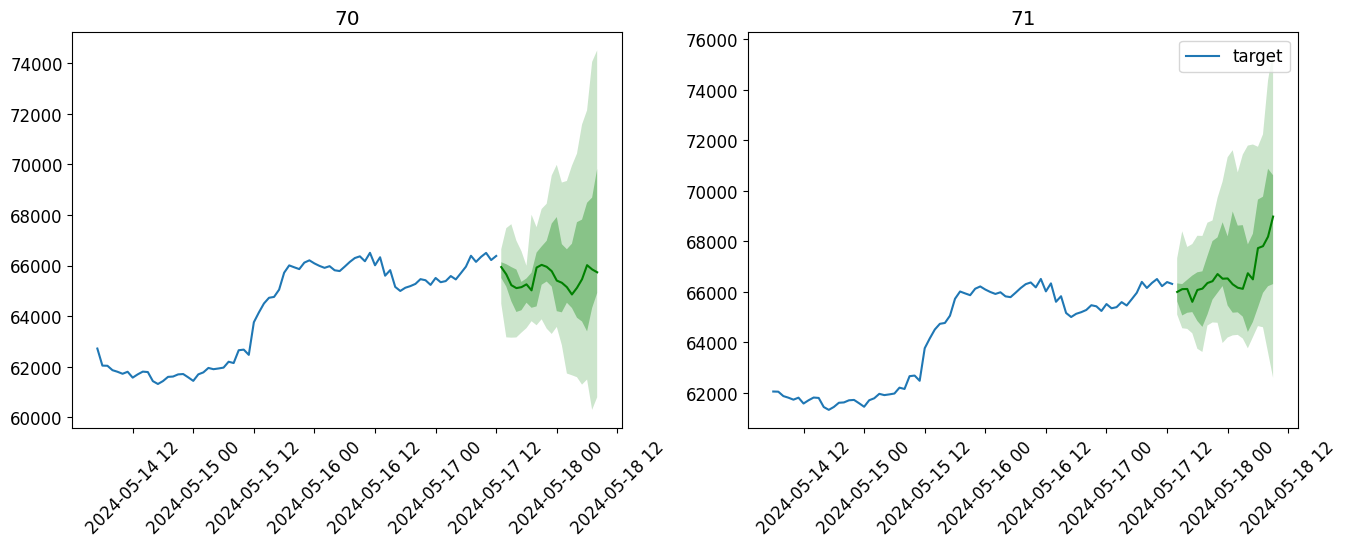

In [42]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%Y-%m-%d %H')
plt.rcParams.update({'font.size': 12})


start = 70
for idx, (forecast, ts) in islice(enumerate(zip(btc_predictions[start:], prediction_context_data[start:]), start), 9):
    ax = plt.subplot(3, 3, idx-start+1)
    
    start_date = ts['start'].to_timestamp()
    freq = ts['start'].freq.name
    y_axis = [start_date + pd.Timedelta(i, unit=freq) for i in range(len(ts['target']))]
    plt.plot(y_axis, ts['target'], label="target", )

    forecast.plot(color='g')
    plt.xticks(rotation=45)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(idx)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [ ]:
# TODO: predicted increases are very optimistic. More finetuning on recent data